In [1]:
import matplotlib
%matplotlib inline

import numpy as np, matplotlib as mpl
from pandas import DataFrame
import PreFRBLE
from PreFRBLE.convenience import *
from PreFRBLE.estimate_redshift import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *
from PreFRBLE.file_system import file_estimated_redshifts_DM


In [2]:
scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18'],
    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
    'N_inter' : True
}

scenario_IGM = {
    'IGM' : ['primordial'],
}


file_tex_redshifts_DM = root_results+"table_redshifts_DM.tex"

### estimate redshift of Spitler Burst
full exemplary redshift estimate for the Spitler burst FRB121102

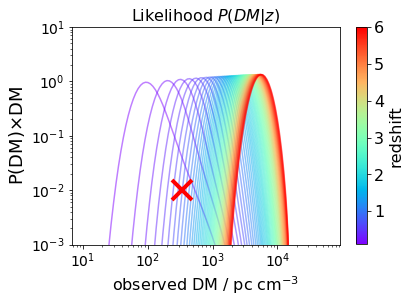

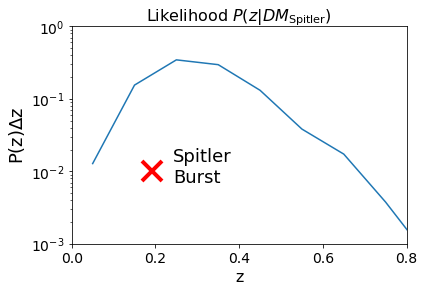

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/matplotlib/axes/_base.py:3157: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


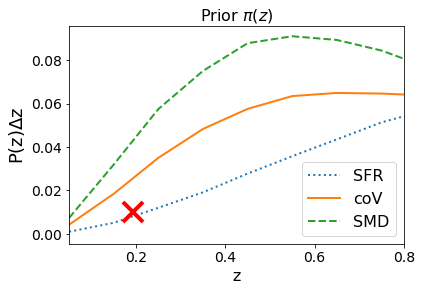

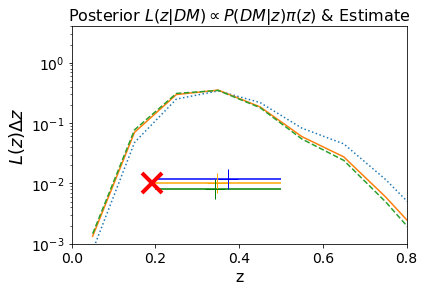

In [12]:
## Spitler burst,  Tendulkar et al. 2017
redshift_spitler = 0.19273
DM_total_spitler = 558 # pc cm^-3, total
DM_spitler = 340 # pc cm^-3, extragalactic = total-MW

sigma=1

telescope='Parkes'  #ARECIBO, actually  !!! PROVIDE prior vor ARECIBO

spitler_kwargs = {'color':'red',  'marker':'x', "markersize":20, 'markeredgewidth':4}

## P(DM|z) evolution with DM-marker
PlotLikelihoodEvolution( measure='DM', scenario=scenario )
plt.plot( DM_spitler, 1e-2, **spitler_kwargs )
plt.title(r"Likelihood $P(DM|z)$", fontsize=16)
plt.ylim(1e-3,10)
plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

## P(z|DM) for flat prior with z-Marker
Ps, z = LikelihoodRedshift( DMs=[DM_spitler], population='flat', telescope='None', scenario=scenario )
PlotLikelihood(x=z, P=Ps[0], measure='z', density=False)
plt.xscale('linear')
plt.plot( redshift_spitler, 1e-2, **spitler_kwargs )
plt.title(r"Likelihood $P(z|DM_{\rm Spitler})$", fontsize=16)
plt.text( redshift_spitler+0.05, 7e-3, 'Spitler\nBurst', fontsize=18 )
plt.xlim(0,.8)
plt.ylim(1e-3,1)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()


## pi(z) priors with z-Marker
fig, ax = plt.subplots()
for population, linestyle in zip( populations, linestyles_population ):
    P, z = GetLikelihood_Redshift( population=population, telescope=telescope)
    PlotLikelihood(x=z, P=P, measure='z', linestyle=linestyle, ax=ax, linewidth=2, label=population, density=False)
ax.set_title("Prior $\pi(z)$", fontsize=16)
ax.set_xlim(0,0.8)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.legend(fontsize=16)
ax.plot( redshift_spitler, 1e-2, **spitler_kwargs )
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()


## P(z|DM)*pi(z) with additional estimated z-Marker
fig, ax = plt.subplots()
colors = ['green','orange','blue']
shift=list(0.8+np.arange(len(populations))/5)
for population, linestyle in zip( populations, linestyles_population ):
    Ps, z = LikelihoodRedshift( DMs=[DM_spitler], population=population, telescope=telescope, scenario=scenario )
    PlotLikelihood(x=z, P=Ps[0], measure='z', linestyle=linestyle, ax=ax, density=False)
    est, dev = Likelihood2Expectation( x=z, P=Ps[0], log=False, density=True, sigma=sigma )
    ax.errorbar( est, 1e-2*shift.pop(), xerr=dev, marker='+', markersize=20, color=colors.pop() )
    
ax.set_title(r"Posterior $L(z|DM) \propto P(DM|z) \pi(z)$ & Estimate", fontsize=16)
ax.set_xscale('linear')
ax.plot( redshift_spitler, 1e-2, **spitler_kwargs )
ax.set_ylabel(r"$L(z)\Delta z$")
ax.set_xlim(0,0.8)
ax.set_ylim(1e-3,4)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()




### Estimate redshifts in FRBcat
Estimate redshift of all FRBs listed in FRBcat using DM, assuming different cosmic populatios.
Write results in numpy array and latex table.

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5


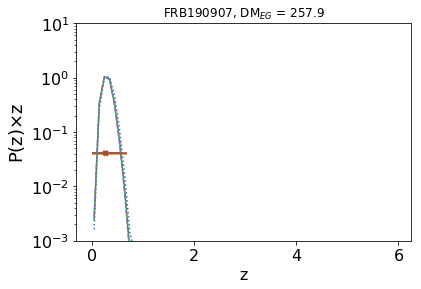

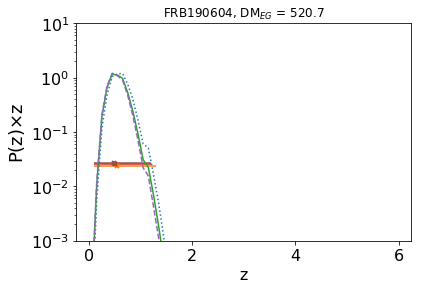

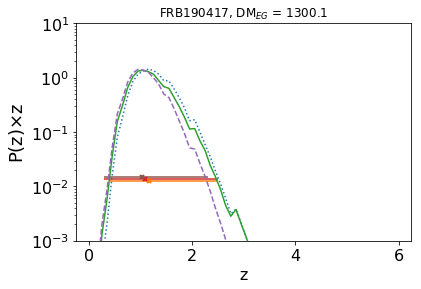

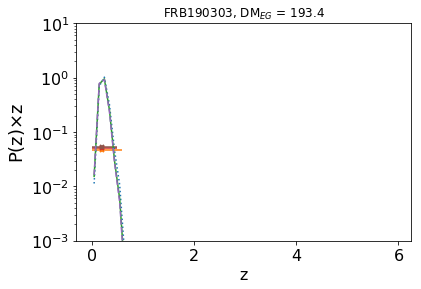

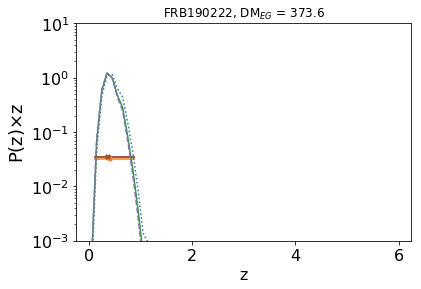

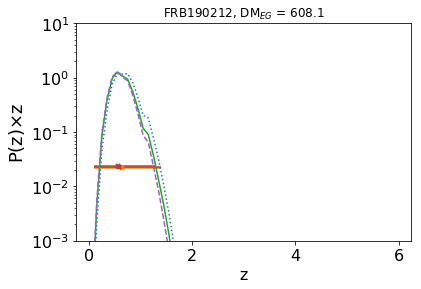

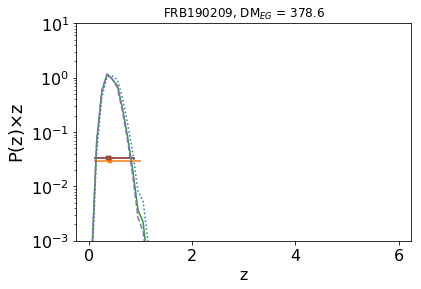

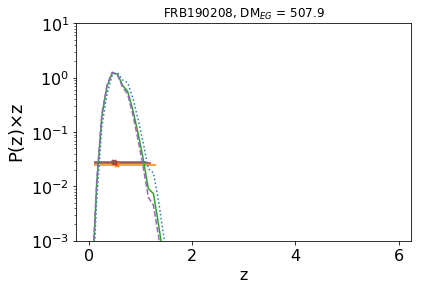

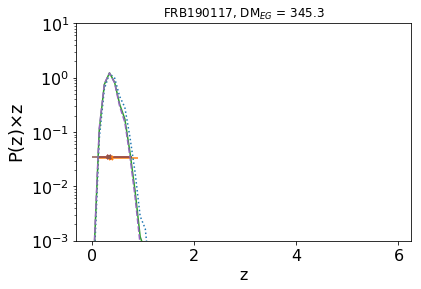

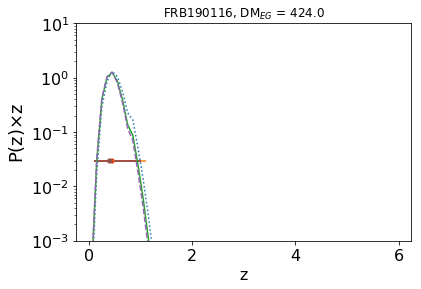

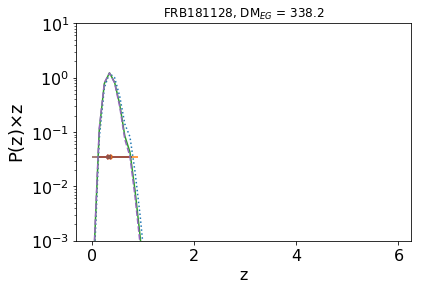

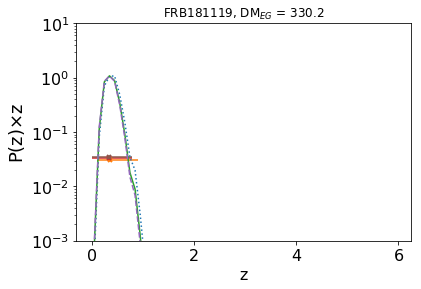

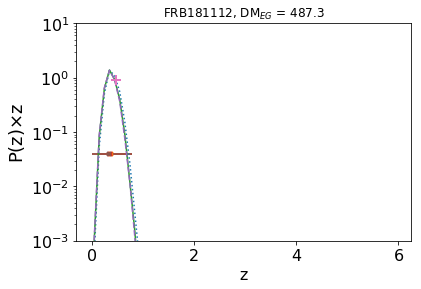

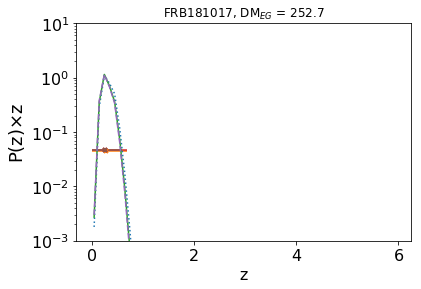

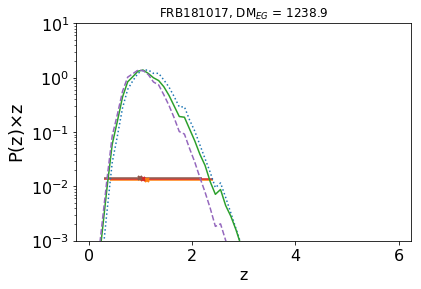

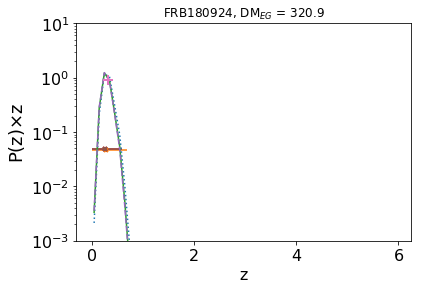

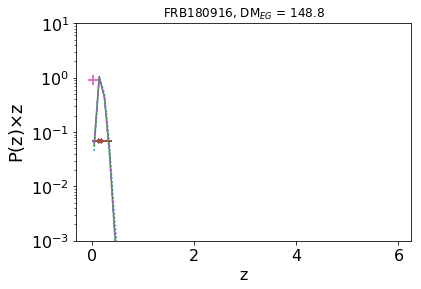

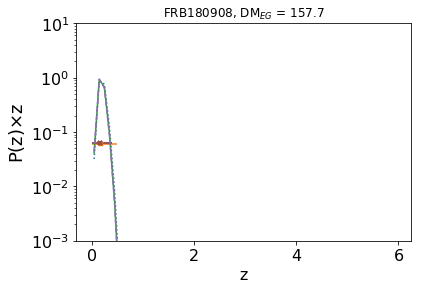

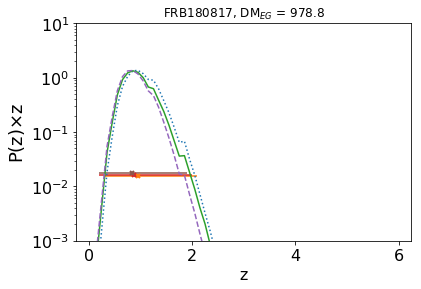

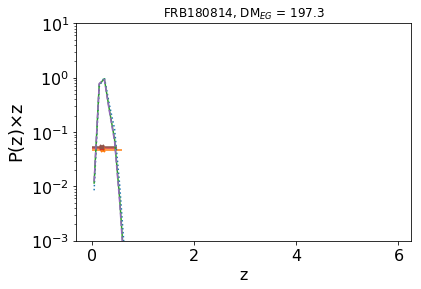

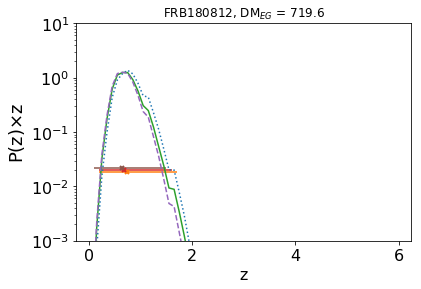

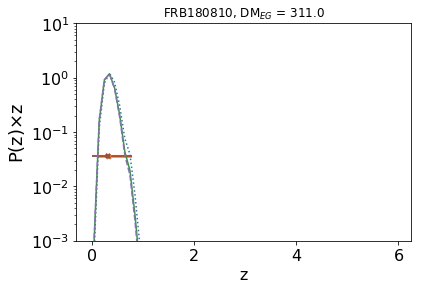

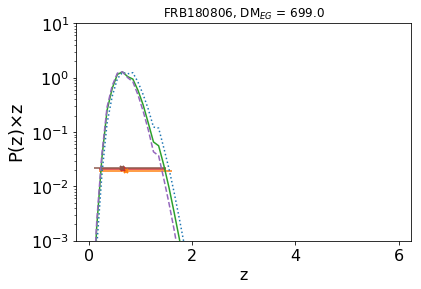

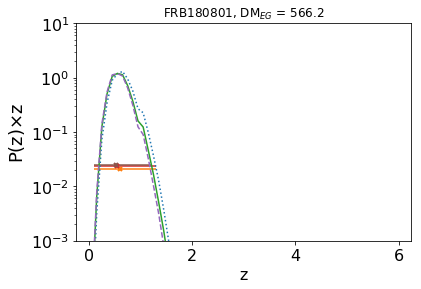

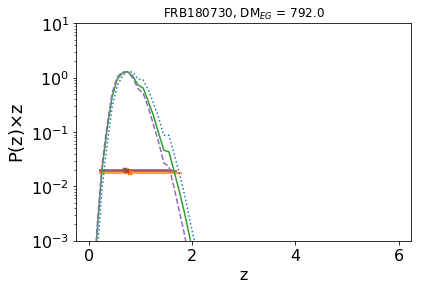

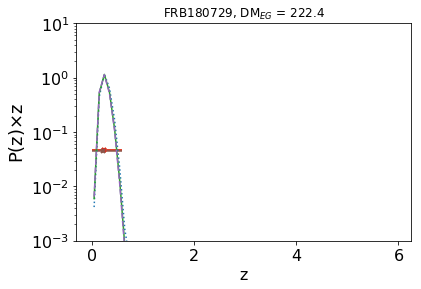

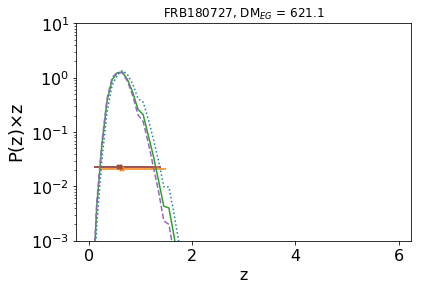

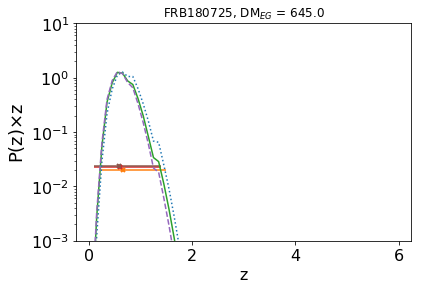

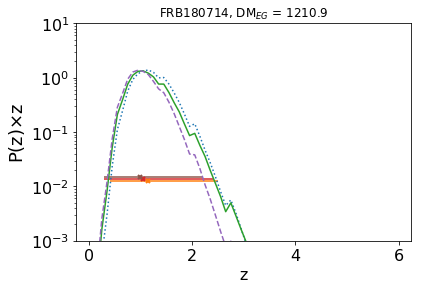

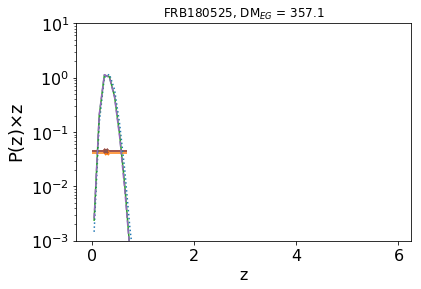

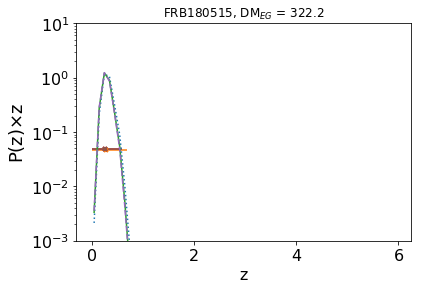

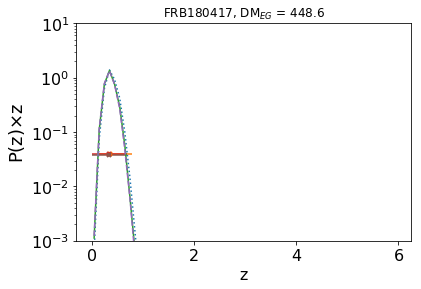

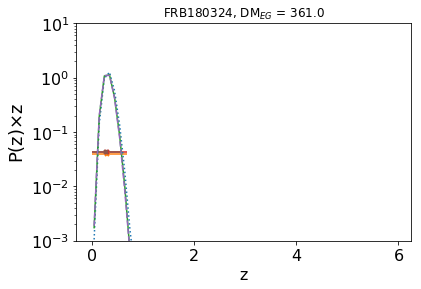

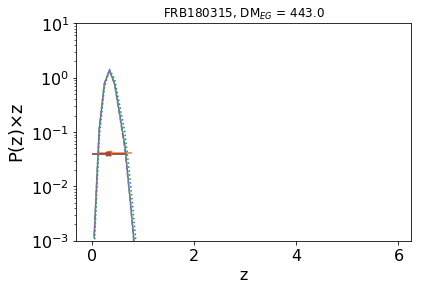

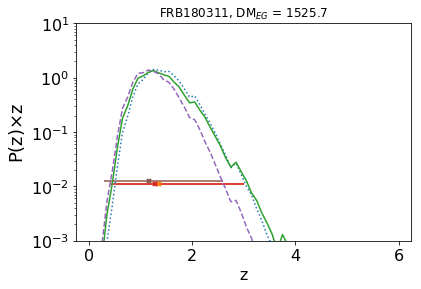

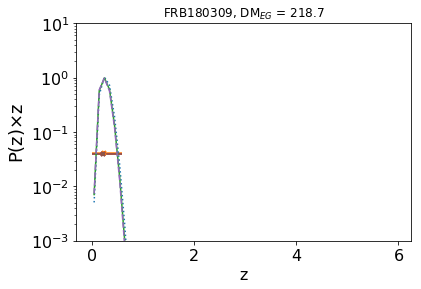

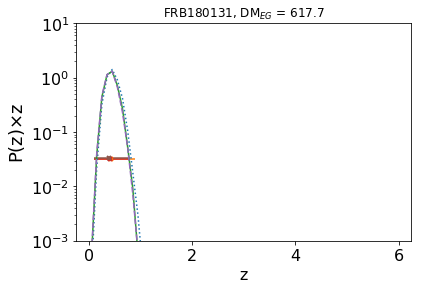

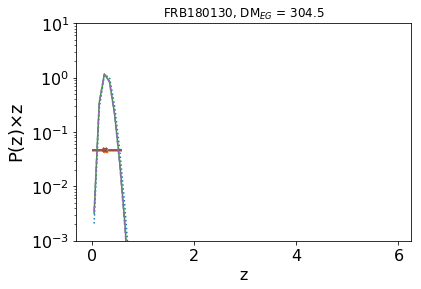

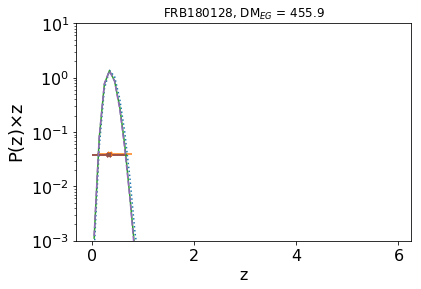

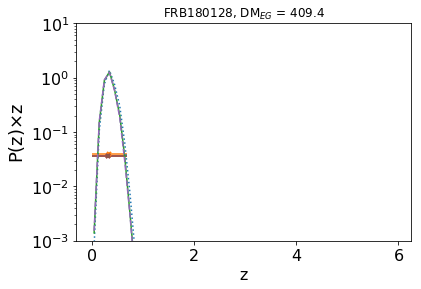

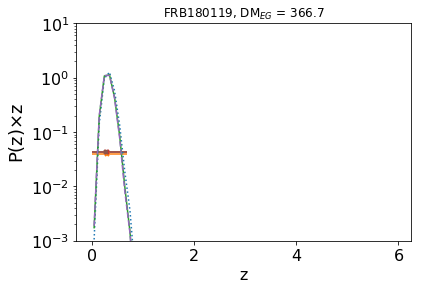

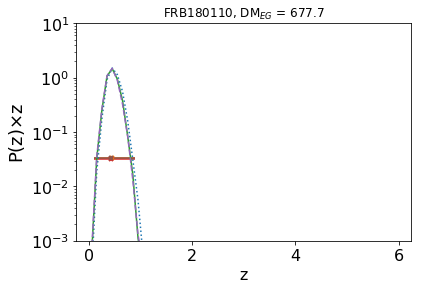

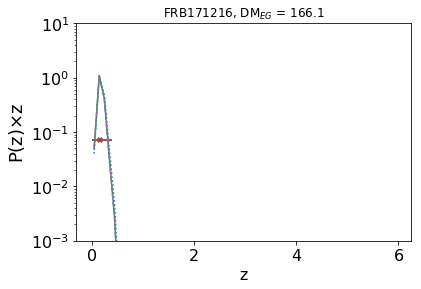

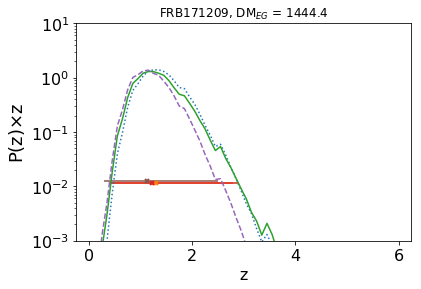

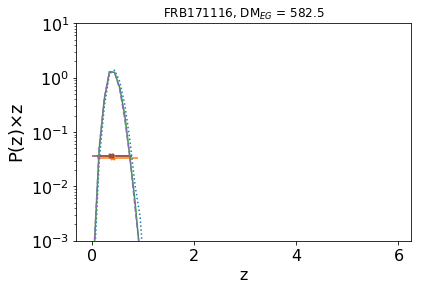

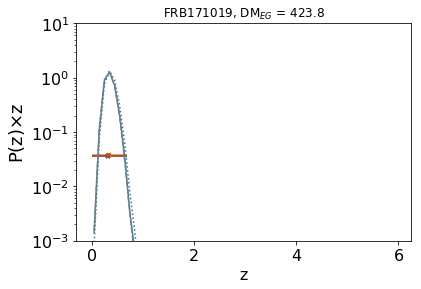

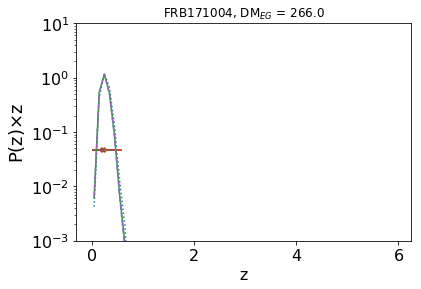

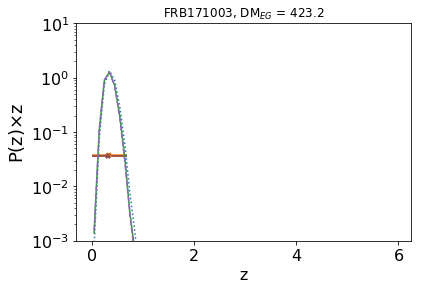

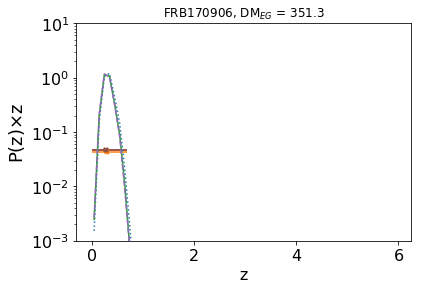

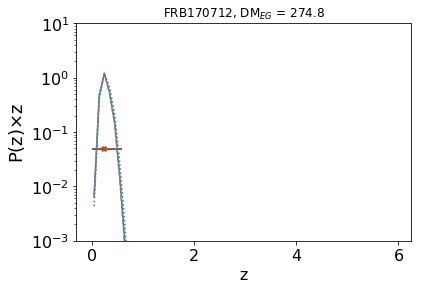

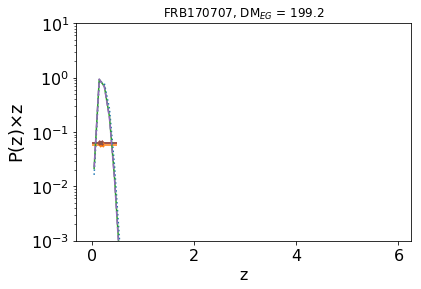

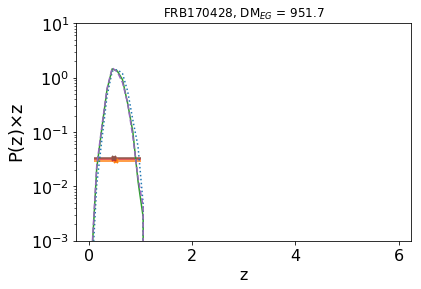

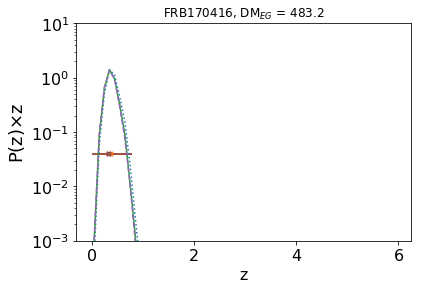

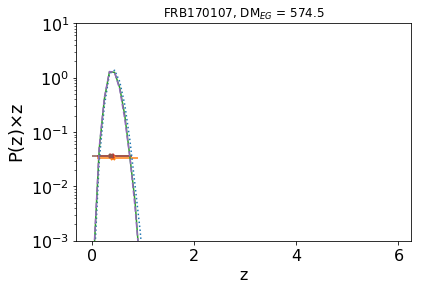

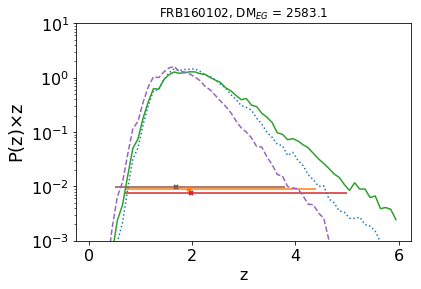

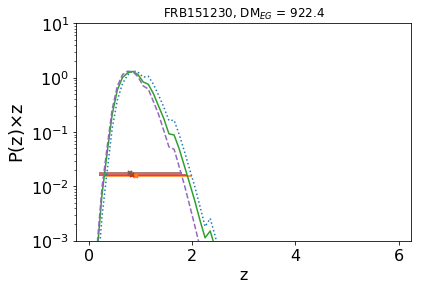

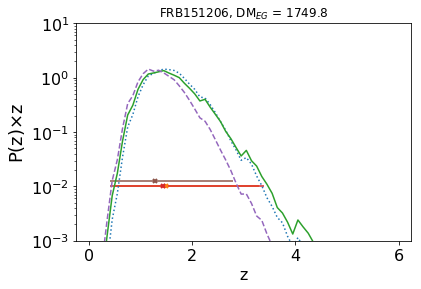

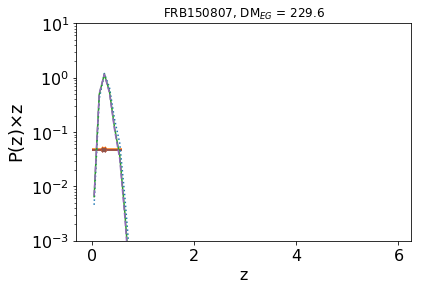

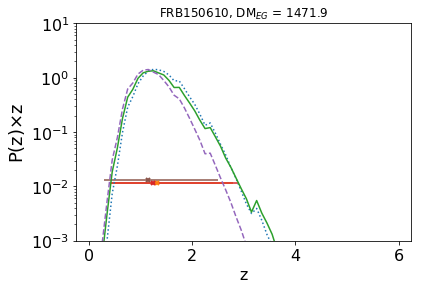

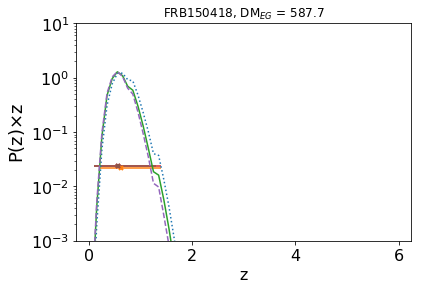

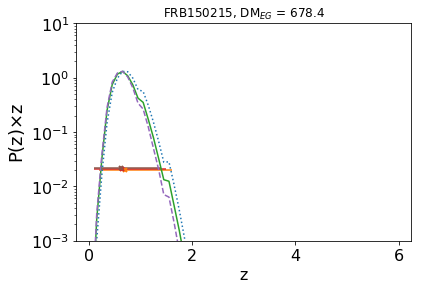

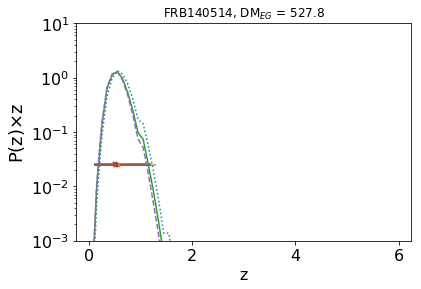

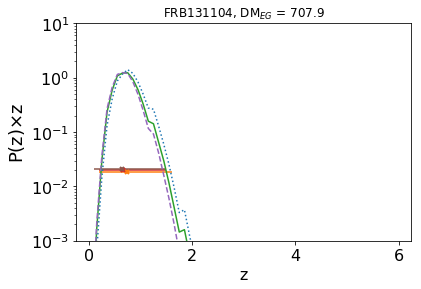

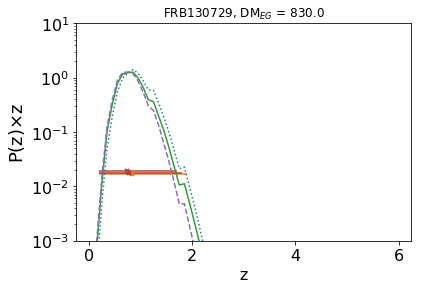

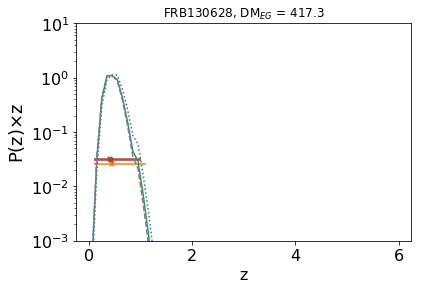

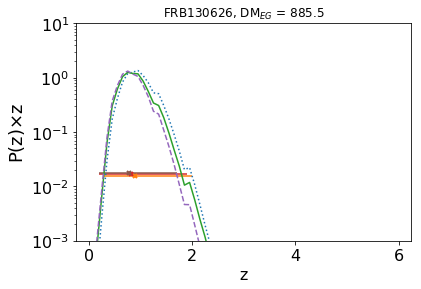

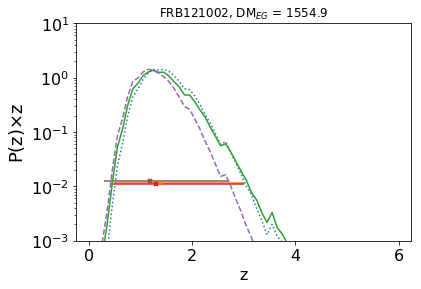

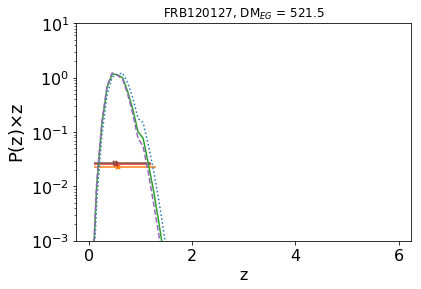

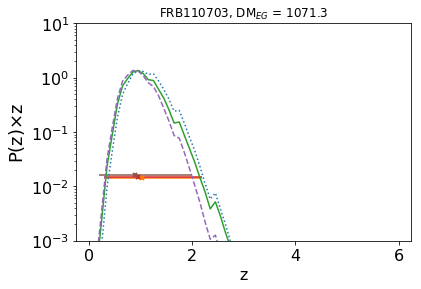

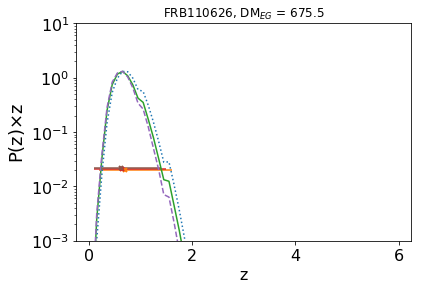

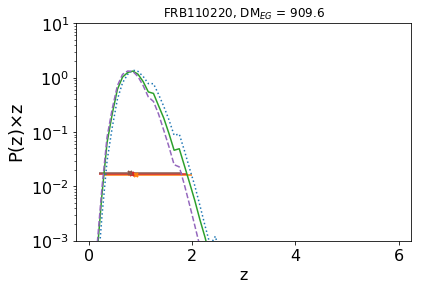

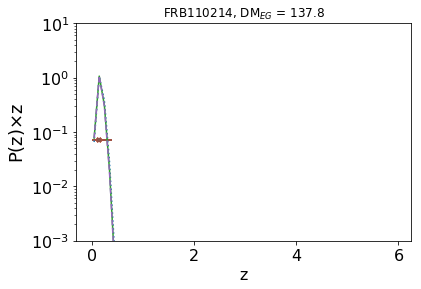

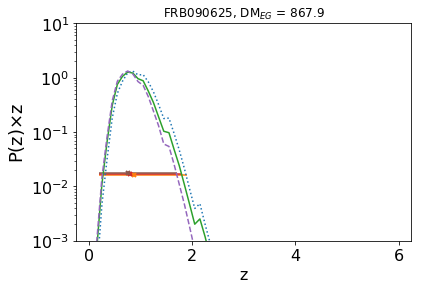

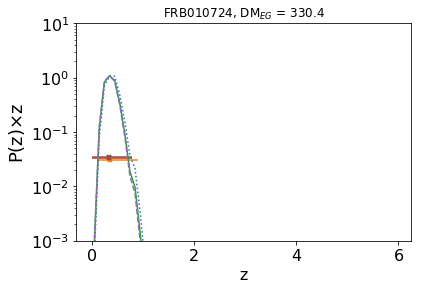

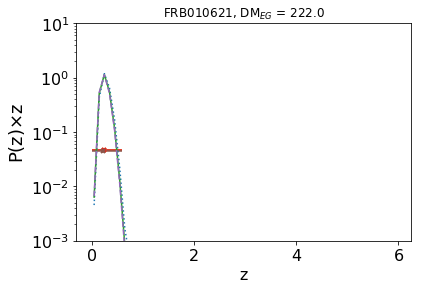

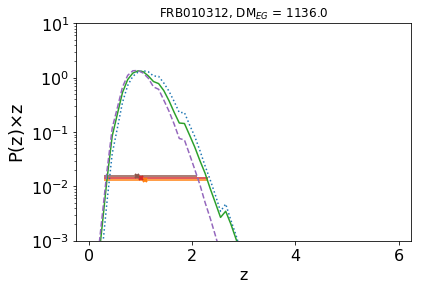

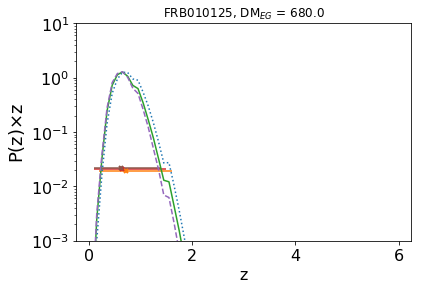

In [13]:
### 

sigma = 3  ## indicate order of sigma deviation to be obtained for <z>, choose >= 3 for lower limits

plot=True

redshift_estimates, deviations, teles = [], [], []

with open( file_tex_redshifts_DM, 'w' ) as f:

    ## prepare header for latex tabular
    f.write( R"\begin{tabular}{l|c|c|c|c|c|c} \n\t" )
    f.write( R"ID & $\DMobs$ / $\unitDM$  & $\DMMW$ / $\unitDM$ & $z_{\rm SMD}(\DM)$  & $z_{\rm SFR}(\DM)$ & $z_{\rm coV}(\DM)$ \\" )
 
    ## load FRBs from FRBcat
    FRBs = GetFRBcat(telescopes=telescopes)

    for FRB in FRBs:
        ## estimate redshift of FRBs based on extragalactic DM, considering all populations and selection effects of the detecting telescope
        ests, devs = RedshiftEstimates( plot=False, DM=FRB['DM']-FRB['DM_gal'], telescope=telescopes_FRBcat_inv[FRB['tele']], scenario=scenario, sigma=sigma )
        
        ## only if redshift can be estimated    some have too low DM and can hence not be located in far Universe. These need to be investigated with the constrained simulation
        if not np.any(np.isnan(ests)):
            ##  collect the FRB and write entry to tabular
            redshift_estimates.append( ests )
            deviations.append( devs )
            tele = telescopes_FRBcat_inv[FRB['tele']]
            teles.append( tele )
#            teles.append( 'ASKAP_incoh' if tele == 'ASKAP' else tele )
            if ests[0] > 0.15:  ## only write down FRBs with reasonable redshift estimates, lowest two bins are z=[0.1,0.2], so nothing below .15 can deliver lower limits
                f.write( "\n\t")
                f.write( R"%s & %.1f & %.1f & $%.2f _{-%.2f} ^{+%.2f}$ & $%.2f _{-%.2f} ^{+%.2f}$ & $%.2f _{-%.2f} ^{+%.2f}$ \\" % ( FRB['ID'], FRB['DM'], FRB['DM_gal'], ests[0], devs[0][0], devs[0][1], ests[1], devs[1][0], devs[1][1], ests[2], devs[2][0], devs[2][1] ) )
                if plot:
                    fig, ax = plt.subplots()
                    RedshiftEstimates( plot=True, DM=FRB['DM']-FRB['DM_gal'], telescope=telescopes_FRBcat_inv[FRB['tele']], scenario=scenario, sigma=sigma, ax=ax )
                    ax.set_ylim(1e-3,10)
                    ax.set_title( "%s, DM$_{EG}$ = %.1f" % (FRB['ID'], FRB['DM']-FRB['DM_gal'] ) )
                    z_host = FRB['host_redshift']
                    if not np.isnan( z_host ):
                        ax.plot( z_host, 0.9, marker='+', markersize=10, markeredgewidth=2 )
                    plt.show()

    ## close tabular
    f.write( "\n")
    f.write( R"\end{tabular}" )

## write redshift estimates to npy file for later use. can be read with GetEstimatedRedshifts
redshift_estimates = np.array(redshift_estimates)
deviations = np.array(deviations)
names = ['redshift/SFR','dev-/SFR', 'dev+/SFR', 'redshift/coV','dev-/coV', 'dev+/coV', 'redshift/SMD','dev-/SMD', 'dev+/SMD', 'telescope']
formats = ['f','f','f','f','f','f','f','f','f','S']
dtype = np.dtype( {'names':names, 'formats':formats})
columns = [ redshift_estimates[:,0], deviations[:,0,0], deviations[:,0,1], redshift_estimates[:,1], deviations[:,1,0], deviations[:,1,1], redshift_estimates[:,2], deviations[:,2,0], deviations[:,2,1], teles ]


a = DataFrame()
for name, data in zip( names, columns ):
    a[name] = data
    
a.to_csv( file_estimated_redshifts_DM, index=False )

#a = np.array( list(zip( *columns )), dtype=dtype )
#np.savetxt( file_estimated_redshifts_DM, a )

#redshift_estimates = np.array(redshift_estimates)
#redshift_estimates.tofile( file_estimated_redshifts_DM, sep=' ')

